# [Logistic Regression and SVM in Python](https://www.datacamp.com/completed/statement-of-accomplishment/course/f8f172c6f52e5a610321984c92a3292517fc66cf)

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/adamelliotfields/datacamp/blob/main/notebooks/machine_learning/logistic_regression_and_svm_in_python/notebook.ipynb)

**Contents**
- [Data](#Data)
- [Linear Classifiers](#Linear-Classifiers)
- [Loss Functions](#Loss-Functions)
- [Logistic Regression](#Logistic-Regression)
- [Support Vector Machines](#Support-Vector-Machines)

## Data

In [1]:
import os
import tarfile
import matplotlib.pyplot as plt
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.datasets import load_digits, load_iris, load_wine
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.svm import SVC
from sklearn.utils import Bunch
from urllib.request import urlretrieve

### Stanford Large Movie Review Dataset

In [2]:
# https://ai.stanford.edu/~amaas/data/sentiment
def load_imdb(data_dir="aclImdb", split="train", fraction=0.1):
    features, labels = [], []
    for label, sentiment in enumerate(["neg", "pos"]):
        path = os.path.join(data_dir, split, sentiment)
        files = sorted(os.listdir(path))[: int(len(os.listdir(path)) * fraction)]
        for file in files:
            with open(os.path.join(path, file), "r", encoding="utf-8") as f:
                features.append(f.read())
                labels.append(label)
    return np.array(features), np.array(labels)


imdb_url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
imdb_tar = "aclImdb_v1.tar.gz"
imdb_dir = "aclImdb"

if not os.path.exists(imdb_tar):
    urlretrieve(imdb_url, imdb_tar)

if not os.path.exists(imdb_dir):
    with tarfile.open(imdb_tar, "r:gz") as tar:
        tar.extractall()

# only use 10% of the data
imdb_train_features, imdb_train_labels = load_imdb(split="train")
imdb_test_features, imdb_test_labels = load_imdb(split="test")
imdb_all_features = np.concatenate([imdb_train_features, imdb_test_features])

# NB: the course uses CountVectorizer
vectorizer = TfidfVectorizer(max_features=2500)  # reduce vocabulary as well
vectorizer.fit(imdb_all_features)

imdb_train_features = vectorizer.transform(imdb_train_features)
imdb_train_labels = imdb_train_labels.astype(np.float64)
imdb_test_features = vectorizer.transform(imdb_test_features)
imdb_test_labels = imdb_test_labels.astype(np.float64)

# bunch for familiar sklearn interface
imdb_train = Bunch(data=imdb_train_features, target=imdb_train_labels, target_names=["neg", "pos"])
imdb_test = Bunch(data=imdb_test_features, target=imdb_test_labels, target_names=["neg", "pos"])

### Digits

In [3]:
# https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html
digits = load_digits()

### Wine

In [4]:
# https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_wine.html
wine = load_wine()

### Iris

In [5]:
iris = load_iris()

## Linear Classifiers

A _decision boundary_ is a surface that separates data points belonging to different classes.

A _linear classifier_ is a classifier that separates data points using a _hyperplane_: a subspace of one dimension less than its ambient space.

For example, in 2D space a plane has length and width. A line is a subspace of the plane, and has length but no width. Any line you draw on that plane will have coordinates within the boundaries of that plane. In 3D space, a plane is like a slice of a cube. The cube has length, width, and height; the plane has only length and width.

If you were to write a linear equation for a subspace, any variables that satisfy that equation will exist within the greater ambient space (i.e., the hyperplane can't "stick out").

Data is _linearly separable_ if it can be separated by a linear decision boundary.

In [6]:
# digits
X_train_digits, X_test_digits, y_train_digits, y_test_digits = train_test_split(
    digits.data,
    digits.target,
    test_size=0.2,
    random_state=42,
)

# fit and score
lr = LogisticRegression(solver="sag", max_iter=1000, random_state=42)
lr.fit(X_train_digits, y_train_digits)
print(lr.score(X_train_digits, y_train_digits))
print(lr.score(X_test_digits, y_test_digits))

1.0
0.9722222222222222


In [7]:
svm = SVC(random_state=42)
svm.fit(X_train_digits, y_train_digits)
print(svm.score(X_train_digits, y_train_digits))
print(svm.score(X_test_digits, y_test_digits))

0.9965205288796103
0.9861111111111112


In [8]:
# imdb
X_train_imdb, X_test_imdb, y_train_imdb, y_test_imdb = train_test_split(
    imdb_train.data,
    imdb_train.target,
    test_size=0.2,
    random_state=42,
)

# fit
lr = LogisticRegression(penalty="l1", solver="saga", random_state=42)
lr.fit(X_train_imdb, y_train_imdb)

# fmt: off
review1, review2 = vectorizer.transform([
    "LOVED IT! This movie was amazing. Top 10 this year.",
    "Total junk! I'll never watch a film by that director again, no matter how good the reviews.",
])
# fmt: on

# `predict_proba` returns a numpy array so we can use fancy indexing
# https://jakevdp.github.io/PythonDataScienceHandbook/02.07-fancy-indexing.html
review1_pred = lr.predict_proba(review1)[0, 1]
review2_pred = lr.predict_proba(review2)[0, 1]
print(f"Review 1 sentiment: {review1_pred:.2%}")
print(f"Review 2 sentiment: {review2_pred:.2%}")

Review 1 sentiment: 96.03%
Review 2 sentiment: 14.32%


## Loss Functions

Scikit-learn's `LinearRegression` class is an implementation of _ordinary least squares_ (OLS) regression. OLS regression minimizes the _sum of squared errors_ (SSE) between the predicted and actual values:

$\text{SSE} = \sum_{i=1}^n (y_i - \hat{y}_i)^2$

where $y_i$ is the actual value, $\hat{y}_i$ is the predicted value for the $i$-th observation, and $n$ is the number of observations.

The _loss function_ in this case is the SSE. When we say "OLS minimizes the SSE", we are saying the model finds the coefficients ($\beta_0, \beta_1, \ldots, \beta_n$) that minimize the SSE, that is, as close to zero as possible.

It's important to distinguish the loss function from scikit-learn's `score` method. The loss is used to fit the model; the score is used to evaluate the model.

### Dot Products

> NB: [Vector notation](https://en.wikipedia.org/wiki/Vector_notation) is either bold ($\mathbf{a}$) or italic with a right arrow ($\vec{a}$).

A _dot product_ is a way to combine two vectors into a single number:

$\mathbf{a} \cdot \mathbf{b} = \sum_{i=1}^n a_i b_i = a_1 b_1 + a_2 b_2 + \cdots + a_n b_n$

where $n$ is the number of dimensions in the vectors, and $i$ is the first dimension to be summed.

In Python, you should use `np.dot()` for dot products and `np.matmul()` (or the `@` operator) for matrix multiplication.

### Raw Model Output

> NB: In the context of math and statistics, use _coefficients_ and _intercept_; in machine learning, use _weights_ and _bias_.

In linear regression, the goal is to predict a continuous variable based on one (simple) or more predictor variables. In this case, the _raw model output_ is the predicted value:

$y = \beta_0 + \sum_{i=1}^n \beta_i x_i$

where $y$ is the predicted value, $\beta_0$ is the intercept, and $\beta_i$ is the coefficient for the $i$-th predictor variable: $x_i$. Or simply:

$\text{output} = \text{intercept} + \text{coefficients} \cdot \text{variables}$

If you were predicting house price based on square footage and number of bedrooms, the raw model output would be the predicted house price, the intercept would be the base price of a house, the coefficient for square footage would be the price per square foot, and the coefficient for number of bedrooms would be the price per bedroom.

In logistic regression, the goal is to predict a binary outcome. In this case, the _raw model output_ is the _log odds_ of the predicted value. The predicted value is passed to a _sigmoid_ function which outputs a probability between 0 and 1. The raw model output is the actual probability before any transformation (e.g., round and multiply by 100 to get a percentage) or interpretation (e.g., if the probability is greater than 0.5, then "yes" otherwise "no").

> NB: Logistic regression can be extended to to multiple classes via _multinomial logistic regression_ which uses a _softmax_ function to output $n$ probabilities for $n$ classes.

The sigmoid function transforms a _logit_ into a probability. In logistic regression, the logit is the output of the linear part of the model before application of the sigmoid function:

$\sigma(x) = \frac{1}{1 + e^{-x}} = \frac{e^x}{1 + e^x} = 1 - \sigma(-x)$

where $x$ is the logit and $e$ is the base of the natural logarithm (Euler's number).

<img src="sigmoid.jpg" alt="Graph of sigmoid function" width="600" />

## Logistic Regression

### Regularization

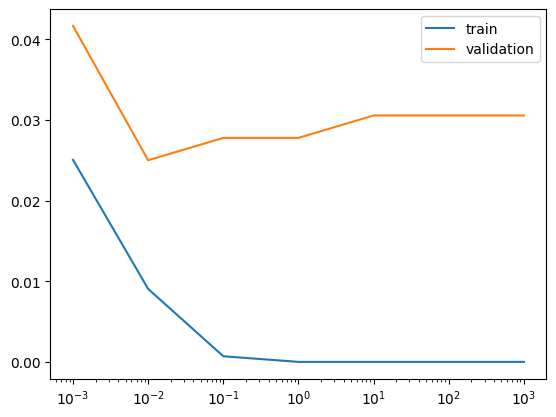

In [9]:
# fit
train_errs = []
valid_errs = []
C_values = [0.001, 0.01, 0.1, 1, 10, 100, 1000]

for C in C_values:
    lr = LogisticRegression(C=C, solver="sag", max_iter=2000, random_state=42)
    lr.fit(X_train_digits, y_train_digits)

    train_err = 1 - lr.score(X_train_digits, y_train_digits)
    valid_err = 1 - lr.score(X_test_digits, y_test_digits)

    train_errs.append(train_err)
    valid_errs.append(valid_err)

# plot
plt.semilogx(C_values, train_errs, C_values, valid_errs)
plt.legend(("train", "validation"))
plt.show()

### Feature Selection

In [10]:
# fit
lr = LogisticRegression(penalty="l1", solver="saga", max_iter=2000, random_state=42)
gs = GridSearchCV(lr, {"C": [0.001, 0.01, 0.1, 1, 10]})
gs.fit(X_train_imdb, y_train_imdb)

# best params
best_params = gs.best_params_
best_estimator = gs.best_estimator_
best_coef = best_estimator.coef_
print(f"Best C: {best_params['C']}")
print(f"Total features: {best_coef.size}")
print(f"Selected features: {np.count_nonzero(best_coef)}")

Best C: 10
Total features: 2500
Selected features: 635


### Multi-class Classification

| One-vs-rest                                    | Softmax                                          |
| ---------------------------------------------- | ------------------------------------------------ |
| fit a binary classifier for each class         | fit a single classifier for all classes          |
| predict all classes and take largest           | predict class directly                           |
| simple but doesn't directly optimize accuracy  | more complicated and directly optimizes accuracy |
| common with SVM                                | not as common with SVM                           |


#### One-vs-rest

In [11]:
lr = LogisticRegression(multi_class="ovr", solver="sag", max_iter=2000, random_state=42)
lr.fit(X_train_digits, y_train_digits)
print(f"OVR train accuracy: {lr.score(X_train_digits, y_train_digits):.2%}")
print(f"OVR test accuracy: {lr.score(X_test_digits, y_test_digits):.2%}")

OVR train accuracy: 99.37%
OVR test accuracy: 95.83%


#### Softmax

In [12]:
lr = LogisticRegression(multi_class="multinomial", solver="sag", max_iter=1000, random_state=42)
lr.fit(X_train_digits, y_train_digits)
print(f"Softmax train accuracy: {lr.score(X_train_digits, y_train_digits):.2%}")
print(f"Softmax test accuracy: {lr.score(X_test_digits, y_test_digits):.2%}")

Softmax train accuracy: 100.00%
Softmax test accuracy: 97.22%


## Support Vector Machines

Logistic regression is a _linear classifier_ that uses a _logistic loss function_ to fit the model.

_Support vector machines_ (SVM) can be classifiers or regressors. They use a _hinge loss function_ to fit the model and L2 regularization to prevent overfitting. SVMs can also use _kernel functions_ to transform the data into a higher dimension to make it linearly separable (aka the _kernel trick_).

### Support Vector

A _support vector_ is a data point that is either close to the decision boundary or incorrectly classified. The distance between the support vectors and the decision boundary is called the _margin_.

Incorrectly classified points are on the wrong side of the decision boundary, but they still play a role in determining the optimal decision boundary. This means that the only examples from your dataset that matter are the support vectors. In other words, the model doesn't need to retain information about the entire dataset, only the support vectors.

The margin is influenced by the regularization strength hyperparameter, $C$. A smaller value of $C$ makes the margin wider, leading to a more generalized model that can tolerate more misclassifications. A larger value of $C$ makes the margin narrower, which means the model will attempt to classify all training examples correctly, leading to a more complex model and overfitting.


### Maximum Margin Classifier

A SVM is a _maximum margin classifier_ because it finds the decision boundary that maximizes the distance between the decision boundary and the nearest data points of each class.

<img src="svm-max-margin.jpg" alt="Figure of a SVM decision boundary" width="600" />

In [13]:
# filter out class 2 to make it binary
X_wine = wine.data[wine.target != 2]
y_wine = wine.target[wine.target != 2]

# fit
svm = SVC(kernel="linear", random_state=42)
svm.fit(X_wine, y_wine)

# score
print(f"Accuracy: {svm.score(X_wine, y_wine):.2%}")
print(f"Original examples: {y_wine.size}")
print(f"Support vectors: {svm.support_.size}")

Accuracy: 100.00%
Original examples: 130
Support vectors: 9


In [14]:
# fit a new model on only support vectors
X_small, y_small = X_wine[svm.support_], y_wine[svm.support_]
svm_small = SVC(kernel="linear", random_state=42)
svm_small.fit(X_small, y_small)
print(f"Accuracy: {svm_small.score(X_small, y_small):.2%}")
print(f"Examples: {y_small.size}")

Accuracy: 100.00%
Examples: 9


### Kernel SVMs

In [15]:
param_grid = {
    "gamma": [0.00001, 0.0001, 0.001, 0.01, 0.1],
    "C": [0.01, 0.1, 1, 10, 100],
}

# fit
svm = SVC(random_state=42)
gs = GridSearchCV(svm, param_grid)
gs.fit(X_wine, y_wine)

# best params
best_params = gs.best_params_
print(f"Best gamma: {best_params['gamma']}")
print(f"Best C: {best_params['C']}")

Best gamma: 0.0001
Best C: 0.1


### Stochastic Gradient Descent

In [16]:
# fit
sgdc = SGDClassifier(random_state=42)
param_grid = {
    "alpha": [0.01, 0.1, 1],
    "loss": ["hinge", "log_loss"],
}
gs = GridSearchCV(sgdc, param_grid, cv=10)
gs.fit(X_train_digits, y_train_digits)

# score
train_score = gs.score(X_train_digits, y_train_digits)
test_score = gs.score(X_test_digits, y_test_digits)
best_params = gs.best_params_
best_score = gs.best_score_
print(f"Train accuracy: {train_score:.2%}")
print(f"Test accuracy: {test_score:.2%}")
print(f"Best alpha: {best_params['alpha']}")
print(f"Best loss: {best_params['loss']}")
print(f"Best score: {best_score:.2%}")

Train accuracy: 97.63%
Test accuracy: 95.83%
Best alpha: 0.1
Best loss: log_loss
Best score: 96.03%


### Visualizing SVM Decision Boundaries

See "[Plot different SVM classifiers in the iris dataset](https://scikit-learn.org/stable/auto_examples/svm/plot_iris_svc.html)" from the scikit-learn docs.

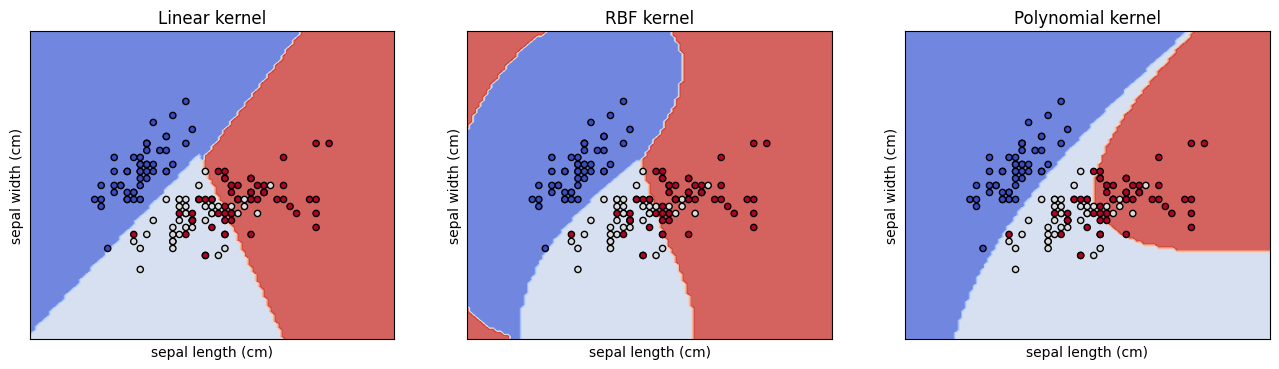

In [17]:
# take first 2 features (sepal length and width)
X_iris = iris.data[:, :2]
y_iris = iris.target

# fit
C = 1.0
models = (
    SVC(kernel="linear", C=C, random_state=42),
    SVC(kernel="rbf", gamma=0.7, C=C, random_state=42),
    SVC(kernel="poly", degree=3, gamma="auto", C=C, random_state=42),
)
models = (clf.fit(X_iris, y_iris) for clf in models)

# plot
titles = (
    "Linear kernel",
    "RBF kernel",
    "Polynomial kernel",
)
fig, sub = plt.subplots(1, 3)
fig.set_size_inches(16, 4)

X0_iris, X1_iris = X_iris[:, 0], X_iris[:, 1]
for clf, title, ax in zip(models, titles, sub.flatten()):
    disp = DecisionBoundaryDisplay.from_estimator(
        clf,
        X_iris,
        response_method="predict",
        cmap=plt.cm.coolwarm,
        alpha=0.8,
        ax=ax,
        xlabel=iris.feature_names[0],
        ylabel=iris.feature_names[1],
    )
    ax.scatter(X0_iris, X1_iris, c=y_iris, cmap=plt.cm.coolwarm, s=20, edgecolors="k")
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title)

plt.show()